### MACHINE LEARNING PROJECT

I'll try to build and train a ML model to predict if a painting is an original paiting from a known artist. I decided to start form a list of 15 artis with a noticeable style difference:
* Andy Warhol
* Caravaggio
* Claude Monet
* Diego Rivera
* Diego Velazquez
* *Edgar Degas (TODO)*
* *Francisco de Goya (TODO)*
* Frida Kahlo
* Gustav Klimt
* Jackson Pollock
* *Joaquín Sorolla (TODO)*
* Katsushika Hokusai
* Pablo Picasso
* Piet Mondrian
* Roy Lichtenstein
* Wassily Kandinsky

I set three objectives:
* Classify if Picasso or Monet
* Classify by *'school' or 'style'*
* Classify by artist

I will use the following characteristics to try to classify the images:
* Colors used
* Hue, saturation and value
* Filling
* Dimension ratio

___

___
### PREREQUISITES

To process images I'll be using OpenCV library. It is important to take a look at the [docs][OpenCV installation and usage] before running the next cell.
For this project I'll use the 'main modules package'

[OpenCV installation and usage]:https://pypi.org/project/opencv-python/

In [10]:
# !pip install opencv-python

___
### IMPORTS

In [1]:
# Modules used for data handling / test
import os
import time

# from utils import item_to_lists, flatten, mklist, nameof


# Modules used for EDA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.patches import Rectangle


# Modules used for image processing
import cv2

from collections import Counter
# from utils import chiaroscuro, hex_to_rgb, fill_ratio, get_img_rgb
# from utils import reduce_col_palette, resize_img, rgb_to_hex, process_color


# Modules used for ML
from sklearn.cluster import KMeans
# from utils import color_quant

In [2]:
# Modules settings
%matplotlib inline

___
### UPDATE UTILS

In [3]:
from utils import item_to_lists, flatten, get_collection, show_collection, mklist, nameof
from utils import chiaroscuro, hex_to_rgb, fill_ratio, get_img_rgb
from utils import reduce_col_palette, resize_img, rgb_to_hex, process_color
from utils import color_quant

In [73]:
# This cell only needs to be executed to update utils
# if modified after them have been imported

%run utils

___
### GETTING IMAGES

In [59]:
path, collection = get_collection('./images/sample_img/', ['.jpg', '.jpeg'])

path, collection

('./images/sample_img/',
 ['sample.jpeg',
  'R&M_01.jpg',
  'R&M_02.jpg',
  'R&M_03.jpg',
  'R&M_04.jpg',
  'R&M_05.jpg'])

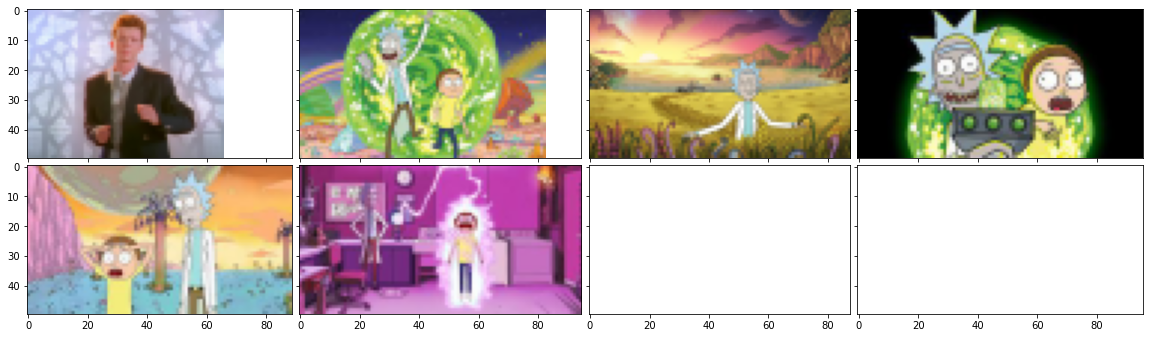

In [74]:
show_collection(path, collection)

In [75]:
# The data found in each image will be stored in this lists
name, ratio, fill_rt, chi_osc, target = mklist(5)
c_01, c_02, c_03, c_04, c_05, c_06, c_07, c_08, c_09, c_10  = mklist(10)

# To make it easier to add elements to every list, a 'superlist' is created
paintings_dset_col = [name, target, ratio, fill_rt, chi_osc,
                  c_01, c_02, c_03, c_04, c_05,
                  c_06, c_07, c_08, c_09, c_10,]

paintings_dset_col

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [52]:
def import_img_data(path, collection, features_lists, target):
    img_errors = 0
    img_errors_log = []
    
    for i in range(len(collection)):
        # Get image and resize
        img_path = path + collection[i]
        img = get_img_rgb(img_path)
        
        # Resize and reduce color palette to 125 colors
        img = resize_img(img, 100)
        img = reduce_col_palette(img, 5)
        
        # Extract data of each image
        try:
            img_name = collection[i].split(sep='.')[0]
            img_ratio = round((img.shape[0] / img.shape[1]) * 2, ndigits=2) / 2
            img_colors, img_palette = color_quant(img, 5, num_of_colors=10, show_chart=False)
            img_fill = fill_ratio(img)
            img_chi_osc = chiaroscuro(img)
            
        except:
            img_errors += 1
            img_errors_log.append(collection[i])
            continue
         
        # Generate flat list with all the data   
        img_data = [img_name, target, img_ratio, img_fill, img_chi_osc]
                
        for i in range(len(img_colors)):
            img_data.append(img_colors[i])
        
        # Add img_data to features_list
        item_to_lists(img_data, features_lists)
        
    return features_lists, img_errors, img_errors_log

features, errors, errors_log = import_img_data(path, collection, paintings_dset_col, 'Sample')

In [53]:
paintings_dset_col

[['sample', 'R&M_01', 'R&M_02', 'R&M_03', 'R&M_04', 'R&M_05'],
 ['Sample', 'Sample', 'Sample', 'Sample', 'Sample', 'Sample'],
 [0.75, 0.6, 0.565, 0.52, 0.56, 0.525],
 [86.3609022556391,
  96.77710843373494,
  98.045197740113,
  96.65104166666667,
  95.76966292134831,
  93.57368421052631],
 [7.329261521377013,
  16500.0,
  185.26315789473685,
  2.162590579710145,
  8850.0,
  273.9130434782609],
 ['#7F7FBF', '#00003F', '#BFBF7F', '#003F00', '#FFFF7F', '#3F003F'],
 ['#3F0000', '#FFFFBF', '#7F7F00', '#FFFFBF', '#7FBFBF', '#FF7FFF'],
 ['#BFFFFF', '#7FBF3F', '#7F3F3F', '#3F7F3F', '#BF7F7F', '#BF3FBF'],
 ['#BFBFBF', '#BFBFBF', '#FFBF7F', '#FFFFFF', '#FFFFBF', '#FFBFFF'],
 ['#BFBFFF', '#3F3F7F', '#FFFFFF', '#FFFF3F', '#FFBF7F', '#BF007F'],
 ['#7F3F3F', '#FFFF3F', '#3F0000', '#7FBF3F', '#7F3F3F', '#7F3F7F'],
 ['#FFFFFF', '#FF7F3F', '#BFBF3F', '#BFBFBF', '#7FBFFF', '#BF7FBF'],
 ['#3F3F00', '#3F7F3F', '#FFBF3F', '#3F3F00', '#FF7FBF', '#7F007F'],
 ['#FF7F7F', '#FFFF7F', '#7F7F3F', '#7F7F7F', '#FFF

___
### IMAGES MANIPULATION

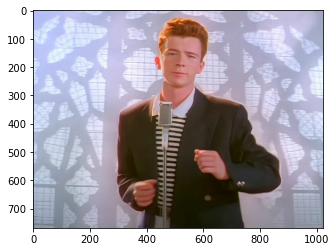

In [9]:
sample = get_img_rgb('./images/sample_img/sample.jpeg')
#sample = get_img_rgb('./images/sample_img/px_nano.jpg')
plt.imshow(sample);

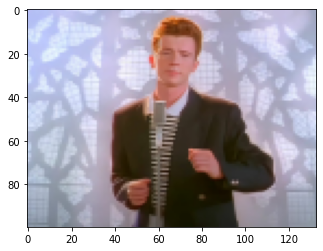

In [10]:
sample = resize_img(sample, 100)
plt.imshow(sample);

Palette reduced to 125 colors.


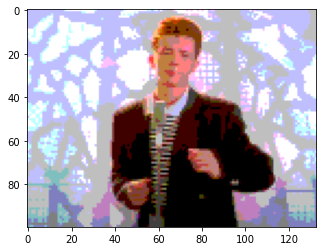

In [11]:
sample = reduce_col_palette(sample, 5, info=True)
plt.imshow(sample);

Colors found:


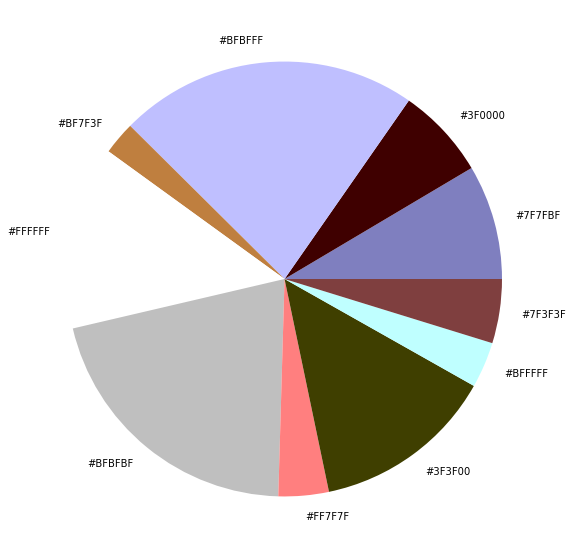

In [21]:
colors, palette = color_quant(sample, 5, num_of_colors=10)

In [25]:
colors

['#7F7FBF',
 '#3F0000',
 '#BFBFFF',
 '#BF7F3F',
 '#FFFFFF',
 '#BFBFBF',
 '#FF7F7F',
 '#3F3F00',
 '#BFFFFF',
 '#7F3F3F']

In [26]:
fill_ratio(sample)

86.3609022556391

In [27]:
chiaroscuro(sample)

7.329261521377013

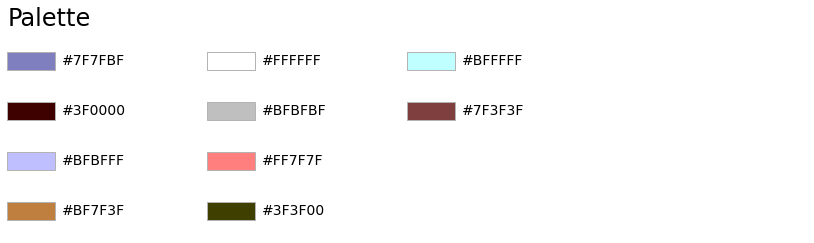

In [77]:
def plot_palette(colors, title, sort_colors=False, emptycols=0):
    cell_width = 200
    cell_height = 50
    swatch_width = 48
    margin = 12
    topmargin = 40

    ### TODO - Sort colors by RGB index
        
    names = list(colors)
    
    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, 
                        margin/height,
                        (width-margin)/width,
                        (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5),
                -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title,
                 fontsize=24,
                 loc="left",
                 pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(Rectangle(xy=(swatch_start_x, y-9),
                               width=swatch_width,
                               height=18,
                               facecolor=colors[name],
                               edgecolor='0.7'))

    return fig

plot_palette(palette, 'Palette',
             sort_colors=True,
             emptycols=1)

plt.show()

___
### TODO / TEST

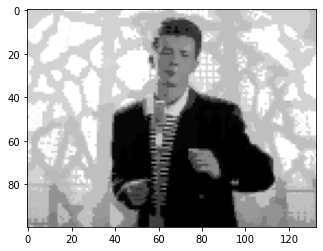

In [22]:
sample_bw = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
plt.imshow(sample_bw, cmap='gray');

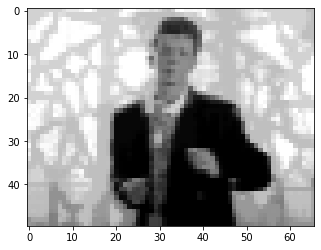

In [23]:
sample_bw = resize_img(sample_bw, 50)
plt.imshow(sample_bw, cmap='gray');

In [24]:
reduce_col_palette(sample_bw, 2);
# color_quant_bw(sample_bw, 8);  ### TODO - color_quant_bw

Palette reduced to 8 colors.
